In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os.path as osp
import os
import random


# Read images

In [8]:
dirname = 'kettle'

images, images_rgb = [], []

for filename in np.sort(os.listdir(dirname)):
    # only read images
    if osp.splitext(filename)[1] in ['.png']:
        im = cv2.imread(osp.join(dirname, filename))
        images += [im]
        images_rgb += [cv2.cvtColor(im, cv2.COLOR_BGR2RGB)]

# number of images
P = len(images)
print('P =', P)

height, width, channel = images[0].shape
print('image shape:', images[0].shape)

P = 13
image shape: (320, 240, 3)


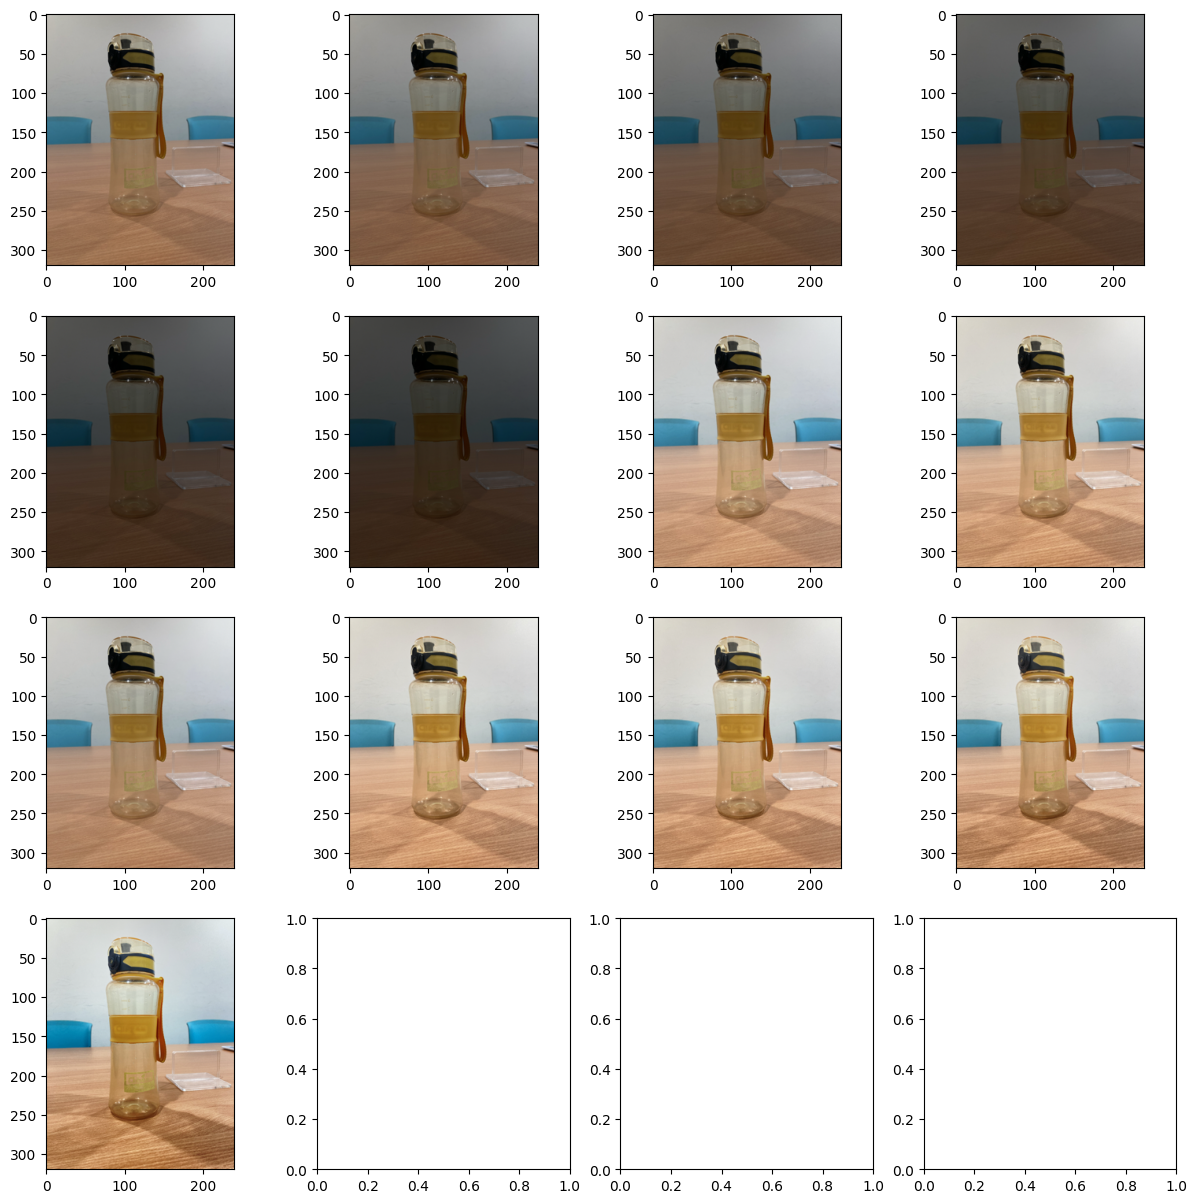

In [7]:
fig, ax = plt.subplots(4, 4, figsize=(15, 15))
for p in range(P):
    row = int(p / 4)
    col = int(p % 4)
    ax[row, col].imshow(images_rgb[p])
plt.show()

# Image Alignment

# Paul E. Debevec method

In [9]:
def gsolve(Z, B, l, w):
    '''
    Arguments:
        Z(i,j): the pixel values of pixel location number i in image j 
        B(j)  : the log delta t, or log shutter speed, for image j
        l     : lamdba, the constant that determines the amount of smoothness
        w(z)  : the weighting function value for pixel value z
        
    Returns:
        g(z)  : the log exposure corresponding to pixel value z
        lE(i) : the log film irradiance at pixel location i
    '''
    
    n = 256
    A = np.zeros((Z.shape[0]*Z.shape[1]+1+(n-2), n+Z.shape[0])) 
    b = np.zeros((A.shape[0], 1))
    
    # Include the data−fitting equations
    k = 0 
    
    for i in range(0, Z.shape[0]):
        for j in range(0, Z.shape[1]):
            wij = w[Z[i,j]]
            A[k, Z[i,j]] = wij
            A[k, n+i] = -wij
            b[k, 0] = wij*B[j]
            k+=1
    
    # Fix the curve by setting its middle value to 0
    A[k, 127] = 1
    k+=1
    
    # Include the smoothness equations
    for i in range(1, n-1):
        A[k, i-1] =    l*w[i]
        A[k, i]   = -2*l*w[i]
        A[k, i+1] =    l*w[i]
        k+=1
    
    # Solve the system using SVD
    x = np.linalg.lstsq(A, b, rcond=None)[0]
    g = x[:n].reshape(-1)
    lE = x[n:].reshape(-1)
    return g, lE